# Real World Data ConvLSTM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from pyseaflux import fCO2_to_pCO2

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-11-14 06:21:13.064299: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 480, axis=0)


def pco2_socat_preprocess(arr):
    nans=np.isnan(arr)
    arr[nans] = 0 
    arr[arr>1000]=0
    return arr

def xco2_preprocess(data):
    output = []
    min_xco2 = np.min(data)
    max_xco2=np.max(data)
    new_min=0
    new_max=255
    
    for d in data:
        num = (d-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
        output.append(num)
    return output

In [3]:
dir_name = "../../data/real_world/MERGED-DATA_1x1_mon_198201-202112.nc"
data = xr.open_dataset(f'{dir_name}')

pco2_converted = fCO2_to_pCO2(data.fco2_ave_unwtd.data,data.sst.data)

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [ ]:
spco2_socat_non

(array([2.0000e+00, 7.0000e+00, 2.1000e+01, 5.6000e+01, 8.6000e+01,
        1.7300e+02, 3.0600e+02, 4.1000e+02, 6.4600e+02, 9.9700e+02,
        1.4670e+03, 2.0590e+03, 3.3200e+03, 5.2700e+03, 1.1782e+04,
        2.5753e+04, 4.9306e+04, 6.6154e+04, 6.4284e+04, 4.7157e+04,
        2.6311e+04, 1.1970e+04, 5.4110e+03, 2.9270e+03, 1.6990e+03,
        9.4800e+02, 4.4500e+02, 2.6100e+02, 1.3200e+02, 8.5000e+01,
        5.5000e+01, 4.2000e+01, 3.4000e+01, 1.4000e+01, 8.0000e+00,
        8.0000e+00, 1.0000e+01, 6.0000e+00, 6.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([ 44.66965724,  62.36448851,  80.05931978,  97.75415105,
        115.44898232, 133.14381359, 150.83864486, 168.53347613,
        186.2283074 , 203.92313867, 221.61796994, 239.31280121,
        257.00763248, 274.70246375, 292.39729502, 310.09212629,
        327.78695756, 345.48178883, 363.1766201 , 380.87145137

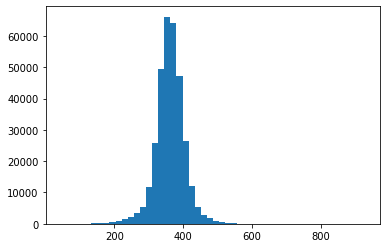

In [15]:
pco2_socat_non = pco2_converted [pco2_converted!=0]
plt.hist(pco2_socat_non,bins=50)

## Data Preprocessing

- min - max scaling ?

In [4]:
chl_images = preprocess_image_reduced(data.chl.data)
sss_images = preprocess_image_reduced(data.sss.data)
sst_images = preprocess_image_reduced(data.sst.data)
dist_map = preprocess_image_reduced(dist_map)
xco2_images = xco2_preprocess(data.atm_pco2_uatm.data)

X= np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
X_all = X.reshape((480,180,360,5),order='F')

y_all = pco2_socat_preprocess(pco2_converted)

INPUT_SHAPE=X_all[0].shape
OUTPUT_SHAPE=y_all[0].shape

INPUT_SHAPE, X_all.shape, y_all.shape

((180, 360, 5), (480, 180, 360, 5), (480, 180, 360))

## Transfer Learning 1
- With 1998 date

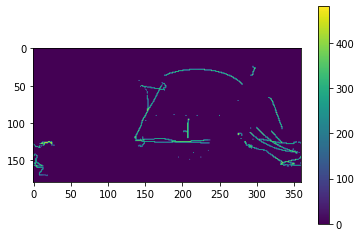

In [5]:
img=plt.imshow(y_all[400])
plt.colorbar(img)

In [75]:
model_path="../../models/base_model/u_net_dist.h5"

cnn_model = tf.keras.models.load_model(model_path, custom_objects={'custom_rmse':custom_rmse})
predicted_image= cnn_model.predict(X_all,verbose=1)
coord=np.isnan(np.repeat(np.expand_dims(data.mask.data,axis=0),480,axis=0))
predicted_image[coord] = 0
y_all[coord]=0

15/15 [==============================] - 1s 71ms/step


In [76]:
# without transfer learning rmse
print(custom_rmse(y_all,predicted_image))

tf.Tensor(290.60327, shape=(), dtype=float32)


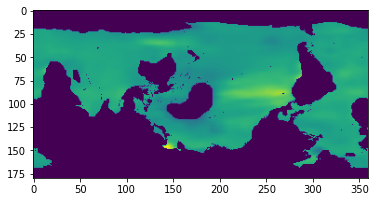

In [21]:
#without any training
plt.imshow(predicted_image[400])

In [26]:
# transfer learning
for layer in cnn_model.layers[:-4]:
    layer.trainable = False


In [33]:
from tensorflow.keras import backend as K
tf.keras.backend.clear_session()
tf.random.set_seed(42)
# best : lr = 0.05 , batch_size = 64

optimizer = keras.optimizers.Adam(learning_rate=0.03)

cnn_model.compile(loss=custom_rmse, optimizer=optimizer)

model_path="../../models/transfer_CNN_real.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = cnn_model.fit(X_all,y_all, epochs=100, 
                         validation_data=(X_all,y_all),
                         workers=-1,batch_size=64,
                         callbacks=callbacks)

Epoch 1/100
8/8 [==============================] - 4s 446ms/step - loss: 140.4006 - val_loss: 146.6436
Epoch 2/100
8/8 [==============================] - 3s 336ms/step - loss: 132.4845 - val_loss: 144.1377
Epoch 3/100
8/8 [==============================] - 3s 337ms/step - loss: 132.2951 - val_loss: 142.6896
Epoch 4/100
8/8 [==============================] - 3s 335ms/step - loss: 128.4128 - val_loss: 142.7078
Epoch 5/100
8/8 [==============================] - 3s 336ms/step - loss: 131.7293 - val_loss: 141.6247
Epoch 6/100
8/8 [==============================] - 3s 337ms/step - loss: 126.6815 - val_loss: 141.4268
Epoch 7/100
8/8 [==============================] - 3s 335ms/step - loss: 131.2720 - val_loss: 140.9979
Epoch 8/100
8/8 [==============================] - 3s 338ms/step - loss: 125.4653 - val_loss: 140.9596
Epoch 9/100
8/8 [==============================] - 3s 336ms/step - loss: 127.8336 - val_loss: 140.7093
Epoch 10/100
8/8 [==============================] - 3s 337ms/step - loss:

In [89]:
#best perfoming : transfer_CNN_real2
#cnn_model = tf.keras.models.load_model('../../models/transfer_CNN_real2.h5', custom_objects={'custom_rmse':custom_rmse})
cnn_model = tf.keras.models.load_model('../../models/transfer_CNN_real.h5', custom_objects={'custom_rmse':custom_rmse})


predicted_image = cnn_model.predict(X_all,verbose=1)
coord=np.isnan(np.repeat(np.expand_dims(data.mask.data,axis=0),480,axis=0))
predicted_image[coord] = 0

15/15 [==============================] - 1s 74ms/step


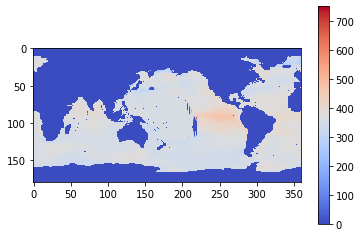

In [90]:
import matplotlib.colors as mcolors


norm = mcolors.Normalize(vmin=0, vmax = 750)

img=plt.imshow(np.flipud(predicted_image[280]),cmap="coolwarm", interpolation="nearest", norm=norm)
plt.colorbar(img)

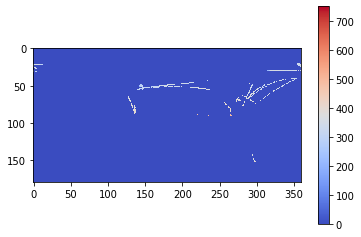

In [91]:
img=plt.imshow(np.flipud(y_all[280]),cmap="coolwarm", interpolation="nearest", norm=norm)
plt.colorbar(img)

In [92]:
custom_rmse(y_all,predicted_image)

<tf.Tensor: shape=(), dtype=float32, numpy=39.33033>

## Transfer learning 2
- after 1998 date

In [62]:
chl_images = preprocess_image_reduced(data.chl.data)
sss_images = preprocess_image_reduced(data.sss.data)
sst_images = preprocess_image_reduced(data.sst.data)
dist_map = preprocess_image_reduced(dist_map)
X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
X = X.reshape((480,180,360,5),order='F')
y = pco2_socat_preprocess(data.fco2_ave_unwtd.data)

X_all = X[192:]
y_all = y[192:]

INPUT_SHAPE=X_all[0].shape
OUTPUT_SHAPE=y_all[0].shape

INPUT_SHAPE, X_all.shape, y_all.shape

((180, 360, 5), (288, 180, 360, 5), (288, 180, 360))

In [63]:
model_path="../../models/base_model/u_net_dist.h5"

cnn_model = tf.keras.models.load_model(model_path, custom_objects={'custom_rmse':custom_rmse})


In [65]:
for layer in cnn_model.layers[:-4]:
    layer.trainable = False

tf.keras.backend.clear_session()

optimizer = keras.optimizers.Adam(learning_rate=0.01)


cnn_model.compile(loss=custom_rmse, optimizer=optimizer)

model_path="../../models/transfer_CNN_real2.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = cnn_model.fit(X_all,y_all, epochs=50, 
                         validation_data=(X_all,y_all),
                         workers=-1,batch_size=32,
                         callbacks=callbacks)

Epoch 1/50
9/9 [==============================] - 3s 275ms/step - loss: 153.9352 - val_loss: 119.4640
Epoch 2/50
9/9 [==============================] - 2s 258ms/step - loss: 129.4935 - val_loss: 128.1852
Epoch 3/50
9/9 [==============================] - 2s 258ms/step - loss: 122.4043 - val_loss: 102.8802
Epoch 4/50
9/9 [==============================] - 2s 258ms/step - loss: 105.0523 - val_loss: 96.0997
Epoch 5/50
9/9 [==============================] - 2s 258ms/step - loss: 103.9604 - val_loss: 87.2156
Epoch 6/50
9/9 [==============================] - 2s 257ms/step - loss: 94.5996 - val_loss: 88.5298
Epoch 7/50
9/9 [==============================] - 2s 258ms/step - loss: 92.3820 - val_loss: 85.3086
Epoch 8/50
9/9 [==============================] - 2s 257ms/step - loss: 90.7703 - val_loss: 79.2675
Epoch 9/50
9/9 [==============================] - 2s 259ms/step - loss: 84.2269 - val_loss: 73.1920
Epoch 10/50
9/9 [==============================] - 2s 256ms/step - loss: 73.7306 - val_loss:

In [ ]:
cnn_model = tf.keras.models.load_model('../../models/transfer_CNN_real2.h5', custom_objects={'custom_rmse':custom_rmse})

predicted_image = cnn_model.predict(X_all,verbose=1)
coord=np.isnan(np.repeat(np.expand_dims(data.mask.data,axis=0),288,axis=0))
predicted_image[coord] = 0

full_truth = data.fco2_ave_unwtd.data[192:]
full_truth[coord] = 0

In [68]:
custom_rmse(full_truth,predicted_image)

<tf.Tensor: shape=(), dtype=float32, numpy=38.310745>

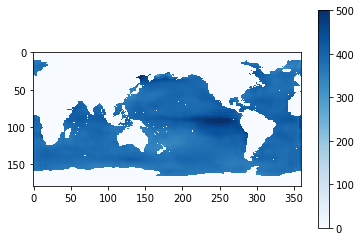

In [69]:
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax = 500)

img=plt.imshow(np.flipud(predicted_image[280]),cmap="coolwarm", interpolation="nearest", norm=norm)
plt.colorbar(img)

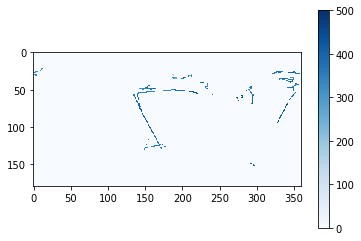

In [70]:
img=plt.imshow(np.flipud(full_truth[280]),cmap="Blues", interpolation="nearest", norm=norm)
plt.colorbar(img)

## ConvLSTM transfer learning

In [94]:
X_index=np.lib.stride_tricks.sliding_window_view(range(480),3)
X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,predicted_image))
X = X.reshape((480,180,360,6),order='F')
X = X[X_index][:-1]

y_tf=np.expand_dims(y_all[X_index][1:],axis=4)

X.shape, y_tf.shape # changed sliding

((477, 3, 180, 360, 6), (477, 3, 180, 360, 1))

In [95]:
tf.keras.backend.clear_session()

convlstm_model_path = "../../models/ConvLSTM_with_pco2_2.h5"
convlstm_model = tf.keras.models.load_model(convlstm_model_path, custom_objects={'custom_rmse':custom_rmse})



In [96]:

tmp = np.nan_to_num(data.fco2_ave_unwtd.data[X_index][1:])
y_true_full = np.expand_dims(tmp,axis=4)
print(y_true_full.shape)

coord = (y_true_full==0.0)

predicted_frames= convlstm_model.predict(X,verbose=1)
predicted_frames[coord] = 0

print("ConvLSTM Full RMSE score w/o finetuning:")
a=custom_rmse(y_true_full[:,1:2],predicted_frames[:,1:2])
print(a)

(477, 3, 180, 360, 1)
15/15 [==============================] - 17s 1s/step
ConvLSTM Full RMSE score w/o finetuning:
tf.Tensor(150.11697, shape=(), dtype=float32)


In [97]:
for layer in convlstm_model.layers[:-2]:
    layer.trainable = False

In [98]:
convlstm_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=2e-3),
)

model_path="../../models/transfer_ConvLSTM_real.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 16

In [99]:
history = convlstm_model.fit(
    X,
    y_tf,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X, y_tf),
    callbacks=callbacks,
)

Epoch 1/50
30/30 [==============================] - 57s 2s/step - loss: 74.8718 - val_loss: 43.5458
Epoch 2/50
30/30 [==============================] - 43s 1s/step - loss: 42.3532 - val_loss: 39.1223
Epoch 3/50
30/30 [==============================] - 43s 1s/step - loss: 38.3768 - val_loss: 36.8664
Epoch 4/50
30/30 [==============================] - 43s 1s/step - loss: 36.6124 - val_loss: 35.6869
Epoch 5/50
30/30 [==============================] - 43s 1s/step - loss: 36.1353 - val_loss: 36.5103
Epoch 6/50
30/30 [==============================] - 43s 1s/step - loss: 35.4528 - val_loss: 34.7724
Epoch 7/50
30/30 [==============================] - 47s 2s/step - loss: 35.0455 - val_loss: 34.5897
Epoch 8/50
30/30 [==============================] - 43s 1s/step - loss: 34.1153 - val_loss: 33.7513
Epoch 9/50
30/30 [==============================] - 43s 1s/step - loss: 33.9100 - val_loss: 33.9125
Epoch 10/50
30/30 [==============================] - 44s 1s/step - loss: 33.6536 - val_loss: 33.4552

KeyboardInterrupt: 

In [100]:
coord=np.isnan(np.repeat(np.expand_dims(data.mask.data,axis=0),480,axis=0)[X_index][1:])
coord.shape

(477, 3, 180, 360)

In [101]:
tf_model = tf.keras.models.load_model("../../models/transfer_ConvLSTM_real.h5", custom_objects={'custom_rmse':custom_rmse})


predicted_frames= tf_model.predict(X,verbose=1)
predicted_frames[coord] = 0
y_true_full[coord]= 0

15/15 [==============================] - 21s 1s/step


In [102]:
print("Full RMSE score:")
a=custom_rmse(y_true_full[:,1:2],predicted_frames[:,1:2])
print(a)

Full RMSE score:
tf.Tensor(31.217478, shape=(), dtype=float32)


/tmp/ipykernel_2937990/2200734154.py:2: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(img)


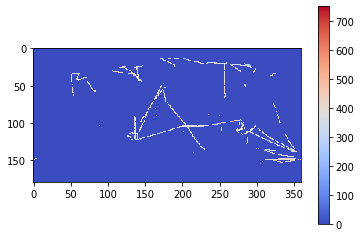

In [103]:
plt.imshow(y_true_full[:,1:2][418][0],cmap="coolwarm",interpolation="nearest", norm=norm)
plt.colorbar(img)

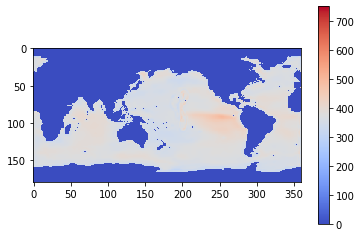

In [104]:
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax = 750)

img=plt.imshow(np.flipud(predicted_frames[418,1:2][0]),cmap="coolwarm", interpolation="nearest", norm=norm)
plt.colorbar(img)

In [ ]:
plt.hist(predicted_frames[predicted_frames!=0.0])

# Gif Generation

In [105]:
# gif generation for convLSTM

import matplotlib.colors as mcolors
import imageio


norm = mcolors.Normalize(vmin=0, vmax = 750)
norm2 = mcolors.TwoSlopeNorm(vmin=-500, vmax = 500, vcenter=0)


filenames = []

for i in range(477):
    figure, axis = plt.subplots(1, 2,figsize=(18, 10))
    frame_pred = predicted_frames[i,1:2][0]
    y_true = y_true_full[i,1:2][0]
    
    img=axis[0].imshow(np.flipud(frame_pred),cmap="coolwarm", interpolation="nearest", norm=norm)
    axis[0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[1].imshow(np.flipud(y_true),cmap="coolwarm", interpolation="nearest",norm=norm)
    axis[1].set_title("true")

    text = "rmse: "+str(np.round(custom_rmse(y_true,frame_pred),2))
    plt.text(-60, -60, text, fontsize = 20)
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
    
    if i%40 == 0:
        print(str(i)+"th photo generated")

with imageio.get_writer('../../assets/convlstm_real_transfer.gif', mode='I',fps=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

0th photo generated
40th photo generated
80th photo generated
120th photo generated
160th photo generated
200th photo generated
240th photo generated
280th photo generated
320th photo generated
360th photo generated
400th photo generated
440th photo generated


In [ ]:
# gif generation for cnn

import matplotlib.colors as mcolors
import imageio


norm = mcolors.Normalize(vmin=0, vmax = 750)


filenames = []

for i in range(480):
    figure, axis = plt.subplots(1, 2,figsize=(18, 10))
    
    img=axis[0].imshow(np.flipud(predicted_image[i]),cmap="coolwarm", interpolation="nearest", norm=norm)
    axis[0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[1].imshow(np.flipud(y_all[i]),cmap="coolwarm", interpolation="nearest",norm=norm)
    axis[1].set_title("true")

    text = "rmse: "+str(np.round(custom_rmse(y_all[i],predicted_image[i]),2))
    plt.text(-60, -60, text, fontsize = 20)
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
    
    if i%40 == 0:
        print(str(i)+"th photo generated")


with imageio.get_writer('../../assets/cnn_real_transfer.gif', mode='I',fps=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

0th photo generated
40th photo generated
80th photo generated
120th photo generated
160th photo generated
200th photo generated
240th photo generated
280th photo generated
320th photo generated
360th photo generated
400th photo generated
440th photo generated
